In [1]:
from lib.controller import Controller
from lib.automation import FileDetector
from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.TSV import RegionExporter
from lib.file.pickle import Pickler
from lib.analysis.align import ImageAlign
import time
import os
import cv2
from lib.utilities import *

In [2]:
dir_base = "C:/Users/jjudge3/Desktop/Data/"
# dir_base = "C:/Users/jjudge3/Desktop/Data/Kate's/"
date = "08-19-22"
data_dir = dir_base + date +"/"
camera_program = 4

quick_test = False

slice_target = [1,2]
rec_target = [i for i in range(0,13)] 
tbs_recording_no = 5
if date == '07-15-22':
    rec_target = [i for i in range(0,17)]  # 7/15
    tbs_recording_no = 5
if date == '07-22-22' and slice_target == 1:
    rec_target = [i for i in range(0,18)]  # 7/19
    tbs_recording_no = 4
if date == '07-22-22' and slice_target == 2:
    rec_target = [i for i in range(0,16)]  
    tbs_recording_no = 5
if date == '07-26-22' and slice_target == 1:
    rec_target = [i for i in range(0,19)]  
    tbs_recording_no = 6
if date == '07-26-22' and slice_target == 2:
    rec_target = [i for i in range(0,16)]  
    tbs_recording_no = 4
if date == '08-01-22':
    slice_target = [1,2]
    rec_target = [i for i in range(11)]  
    tbs_recording_no = 4
if date == "11-30-21":
    rec_target = [2]
if date == "08-19-22":
    slice_target = [1,2]
    rec_target = [i for i in range(0,13)] 

load_dic = True
enable_alignment = True
align_only_first_rec = True  # instead of asking for a separate alignment for each recording
num_regions_to_export = 5  # max number of regions per record to export to PhotoZ
process_all = False  # overrides slice/rec target to process all files

time_course_types = ['Max', 'Avg', 'Num ROIs', 'df/f']
time_course_choice = 2  # index

# recording schedule
int_trial = 10
num_trial = 5
int_recording = 45

actual_int_recording = int_trial * num_trial + int_recording

#cluster settings
sampling_size = 100000
k_cluster = 95  # set to None for AIC elbow plotting
# cluster filter settings
n_pixel_cutoff = 3  # maximum cluster size allowed
average_snr_cutoff_percentile = 50  # cluster-specific percentile

if quick_test:
    k_cluster = 10
    slice_target = [slice_target[0]]
    rec_target = rec_target[0:3]

# save time loading and clustering data by loading a saved run
save = True
restore_pickle = None  # saved run index to load, or None. 
save_pickle_index = 0  # save run index to save, or None. Will find higher index to avoid overwrite
if not save:  # then load
    restore_pickle, save_pickle_index = save_pickle_index, restore_pickle

1-1.tif
1-1e.tif
1-1f.tif
2-1.tif
2-1e.tif
2-1f.tif
(82, 98)


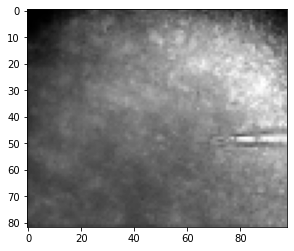

In [3]:
# read in 8-bit single TIF images to array, apply same cropping/binning
single_images = {}
dic_dir = data_dir + "dic/"
cam_settings = CameraSettings().get_program_settings(camera_program)
binning = int(2048 / 80) # if want size similar to RLI

if load_dic and restore_pickle is None:
    TIFLoader(dic_dir, cam_settings, binning, crop=False, flip_horiz=True).load_files(single_images, slice_target=slice_target[0])
    
print(list(single_images[slice_target[0]].values())[0]['i'].shape)

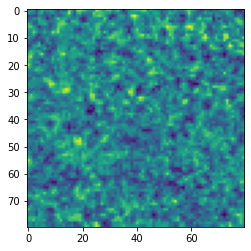

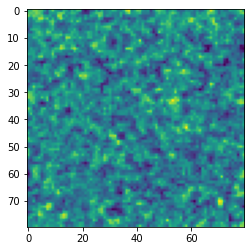

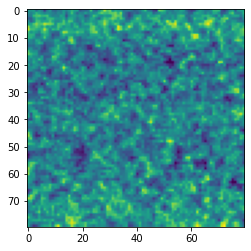

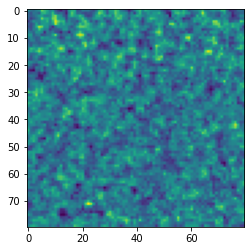

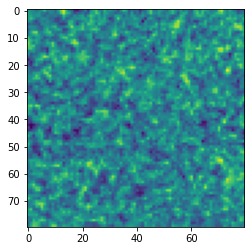

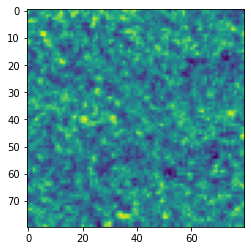

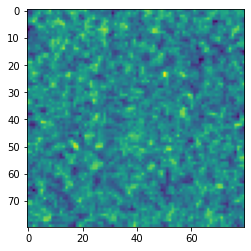

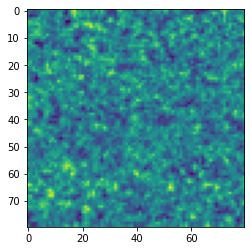

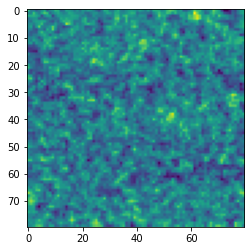

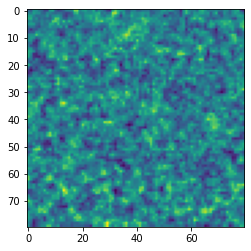

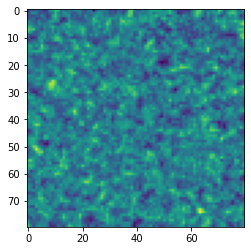

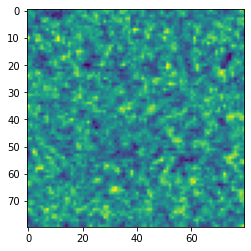

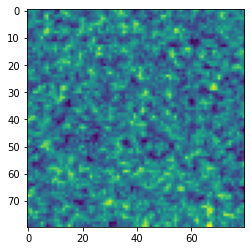

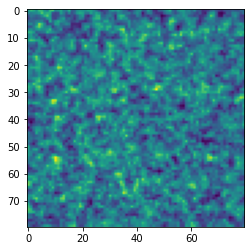

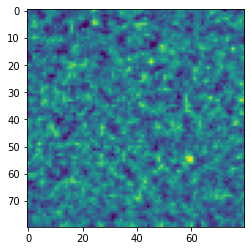

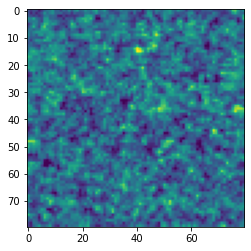

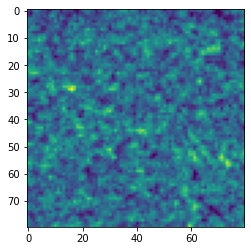

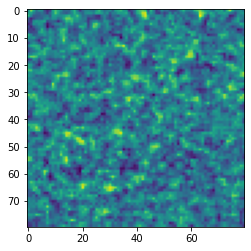

In [4]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, RLI, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
if restore_pickle is None:
    for filename in os.listdir(dat_dir):
        if (filename.endswith(".dat") or filename.endswith(".txt")) and filename[:3] != "ROI":
            map_type = filename[:3]
            name_parse = filename.split('.')[0][-8:]
            try:
                slic, loc, rec = [int(x) for x in name_parse.split('_')]
            except ValueError:
                continue
            if slic not in single_images:
                single_images[slic] = {}
            if loc not in single_images[slic]:
                single_images[slic][loc] = {}
            if map_type not in single_images[slic][loc]:
                single_images[slic][loc][map_type] = {}
            dat = np.loadtxt(dat_dir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(dat.shape[0]))
            dat = dat.reshape((width, width))
            if map_type == "SNR" and slic in slice_target and rec in rec_target:
                plt.imshow(dat)
                plt.show()
            single_images[slic][loc][map_type][rec] = {
                'data': dat,
                'filename': filename}


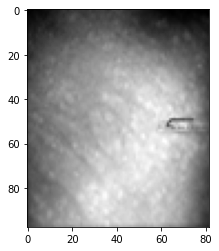




 *********** Slice 1, Loc 1, Rec 1 *********** 


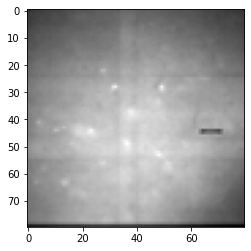

pyimage3
[0, 0]



 *********** Slice 1, Loc 1, Rec 2 *********** 



 *********** Slice 1, Loc 1, Rec 3 *********** 



 *********** Slice 1, Loc 1, Rec 4 *********** 



 *********** Slice 1, Loc 1, Rec 5 *********** 



 *********** Slice 1, Loc 1, Rec 6 *********** 



 *********** Slice 1, Loc 1, Rec 7 *********** 



 *********** Slice 1, Loc 1, Rec 8 *********** 



 *********** Slice 1, Loc 1, Rec 9 *********** 



 *********** Slice 1, Loc 1, Rec 10 *********** 



 *********** Slice 1, Loc 1, Rec 11 *********** 



 *********** Slice 1, Loc 1, Rec 12 *********** 


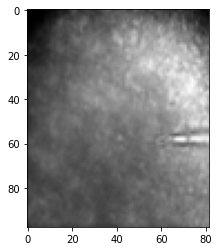




 *********** Slice 2, Loc 1, Rec 1 *********** 


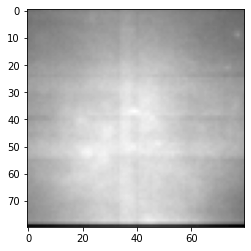

pyimage7
[0, 0]



 *********** Slice 2, Loc 1, Rec 2 *********** 



 *********** Slice 2, Loc 1, Rec 3 *********** 



 *********** Slice 2, Loc 1, Rec 4 *********** 



 *********** Slice 2, Loc 1, Rec 5 *********** 



 *********** Slice 2, Loc 1, Rec 6 *********** 


In [5]:
# align RLI and DIC and record the RLI's image boundaries within the DIC image.
img_aligner = ImageAlign()
if enable_alignment:

    for slic in single_images:
        for loc in single_images[slic]:

            # DICs
            fluor = single_images[slic][loc]['f']
            # img = single_images[slic][loc]['i']
            dic_electrode = single_images[slic][loc]['e']
            dic_electrode = np.array(dic_electrode, dtype=np.uint8)
            
            if len(single_images[slic][loc]['SNR'].keys()) > 0:
                # ask user to trace out shape of electrode (and/or other features)
                dic_electrode = np.array(img_aligner.draw_on_image(dic_electrode))
                plt.imshow(dic_electrode, cmap='gray')
                plt.show()
                first_alignment = None
            
            for rec in single_images[slic][loc]['SNR']:

                if (process_all or (slic in slice_target and rec in rec_target)) and restore_pickle is None:
                    
                    print("\n\n\n *********** Slice", str(slic) + ", Loc", str(loc) + ", Rec", str(rec), "*********** ")
                    
                    if align_only_first_rec and first_alignment is not None:
                        single_images[slic][loc]['RLI'][rec]['alignment'] = first_alignment
                        continue

                    rli = single_images[slic][loc]['RLI'][rec]['data']
                    rli = np.array(rli * 255, dtype=np.uint8)
                    rli = np.array(img_aligner.draw_on_image(rli))
                    plt.imshow(rli, cmap='gray')
                    plt.show()
                    
                    alignment_corners = []
                    
                    # user drags image to align
                    nw_drag_corner = img_aligner.drag_to_align(dic_electrode, rli)
                    print(nw_drag_corner)
                    
                    # store alignment info
                    single_images[slic][loc]['RLI'][rec]['alignment'] = alignment_corners
                    if align_only_first_rec:
                        first_alignment = single_images[slic][loc]['RLI'][rec]['alignment']


In [6]:
roi = ROI_Identifier()
reg_exp = RegionExporter()

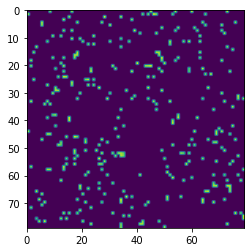

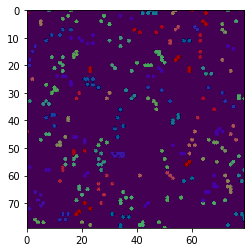

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs80-SNR01_01_01.dat


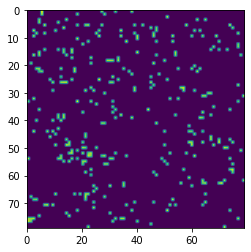

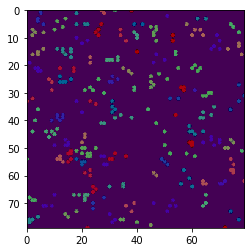

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs85-SNR01_01_01.dat


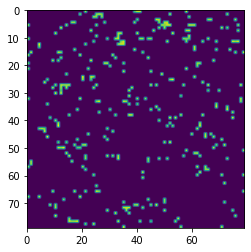

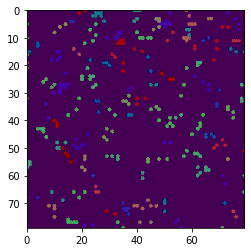

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs90-SNR01_01_01.dat


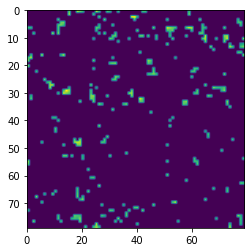

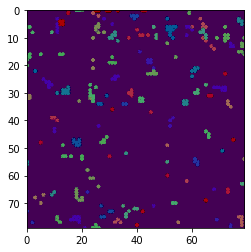

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs95-SNR01_01_01.dat


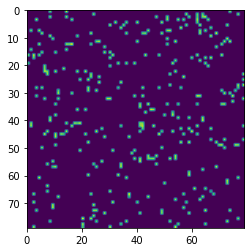

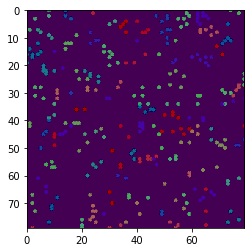

Regions written to: C:/Users/jjudge3/Desktop/Data/08-19-22/converted_zda/ROIs80-SNR01_01_02.dat


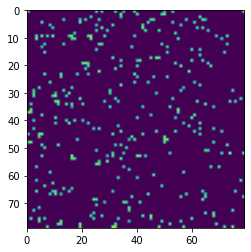

In [ ]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

percentile_strata = [[80, 85], [85, 90], [90, 95], [95, 100]]
if quick_test:
    percentile_strata = [[90, 95], [95, 100]]


for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        for rec in single_images[slic][loc]['SNR']:
            
            if (process_all or (slic in slice_target and rec in rec_target)) and restore_pickle is None:
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = []

                for stratum in percentile_strata:
                    low_cutoff, hi_cutoff = stratum

                    sampled_points = roi.generate_points(snr, n_points=sampling_size, 
                                                         percentile_cutoff=low_cutoff,
                                                         upper_cutoff=hi_cutoff)

                    roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                    k = k_cluster

                    if k is None:
                        # use AIC and elbow method, then enter choice of k above
                        roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
                        break
                    else: # after manually selecting k
                        labels = roi.gaussian_mixture_model(sampled_points, k, show=False)

                        roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)

                        # print ROIs to a DAT file to be loaded into PhotoZ
                        filename = dat_dir + "ROIs" + str(low_cutoff) + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        regions = roi_write.export_clusters(filename, labels, sampled_points, w, limit=num_regions_to_export)
                        all_regions_by_pixel = roi_write.get_regions_by_pixel()
                        # regions is in format of doubly-nested list of PhotoZ diode numbers

                        cluster_objs = []
                        for px_region in all_regions_by_pixel:
                            cluster_objs.append(Cluster(px_region, w))
                            
                        cluster_strata.append(cluster_objs)
                        single_images[slic][loc]['SNR'][rec]['cluster_strata'] = cluster_strata

In [ ]:
# save/load point: pickle all objects to "last run" in current working directory. Also loads if restore_pickle is True
Pickler(dir_base, date, save_pickle_index, restore_pickle, slice_target[0]).process_pickle(single_images)

In [ ]:
for slic in single_images:
    for loc in single_images[slic]:
        print(slic, loc)
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])
                
                # Split non-contiguous clusters until contiguous
                for stratum in cluster_strata:
                    extra_clusters = []
                    for cluster in stratum:
                        new_clusters = cluster.attempt_split()
                        extra_clusters += new_clusters
                    stratum += extra_clusters
                
                # Filter clusters by size
                for stratum in cluster_strata:
                    for i in range(len(stratum)-1, -1, -1):  # strata 1 is the lower-SNR strata
                        if stratum[i].get_cluster_size() > n_pixel_cutoff:
                            del stratum[i]
                            
                # Filter clusters by avg SNR
                for stratum in cluster_strata:
                    if len(stratum) > 1:
                        stratum_snrs = np.array([cluster.get_cluster_snr(snr) for cluster in stratum])
                        snr_cutoff = np.percentile(stratum_snrs, average_snr_cutoff_percentile)
                        for i in range(len(stratum_snrs)-1, -1, -1):
                            if stratum_snrs[i] < snr_cutoff:
                                del stratum[i]

                # filter adjacent (touching) clusters of different clusters -- remove the lower-SNR one. 
                for i in range(len(cluster_strata)):
                    stratum1 = cluster_strata[i]
                    for j in range(i+1, len(cluster_strata)):
                        stratum2 = cluster_strata[j]
                        for ic_1 in range(len(stratum1)-1, -1, -1):  # stratum 1 is the lower-SNR stratum
                            for c2 in stratum2:
                                if stratum1[ic_1].is_adjacent_to(c2):
                                    del stratum1[ic_1]
                                    break
                                    
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])


In [ ]:
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                                                    
                # consolidate strata and show all surviving ROIs
                plt.clf()
                j_label = 0
                for i in range(len(cluster_strata)):
                    stratum = cluster_strata[i]
                    if len(stratum) > 0:
                        pixels = []
                        labels = []
                        for c in stratum:
                            new_pixels = c.get_pixels()
                            pixels += new_pixels
                            labels += [j_label for _ in range(len(new_pixels))]
                            j_label += 1
                        pixels = np.array(pixels)
                        roi.draw_gmm_enclosures(pixels, labels, a=0.5, s=10, 
                                                show=False, 
                                                plot_sample_heatmap=False,
                                                overlay_image=single_images[slic][loc]['RLI'][rec]['data'])
                        filename = dat_dir + "ROIs-highest" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        
                        # export only the highest SNR clusters.
                        regions = roi_write.export_clusters(filename, labels, pixels, w, 
                                                            limit=num_regions_to_export,
                                                            snr=snr)

                        # Export ROIs to ImageZ format for region drawing
                        all_px_regions = roi_write.get_regions_by_pixel()
                        filename = dat_dir + "ImageZ" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        filename = filename[:-4] + ".tsv"
                        reg_exp.export(filename, all_px_regions)
                        
                        single_images[slic][loc]['SNR'][rec]['final_ROIs'] = all_px_regions
                        single_images[slic][loc]['SNR'][rec]['final_ROIs_filename'] = filename
                    
                plt.show()

In [ ]:
i_dff = 0
for slic in single_images:
    for loc in single_images[slic]:
        rec_time_course = []
        if process_all or (slic in slice_target and rec in rec_target): 
            for rec in single_images[slic][loc]['SNR']:

                snr = single_images[slic][loc]['SNR'][rec]['data']
                max_amps = None
                rli_pre_stim = None
                try:
                    max_amps = single_images[slic][loc]['Amp'][rec]['data']
                    rli_pre_stim = single_images[slic][loc]['nos'][rec]['data']
                except Exception as e:
                    print(e)
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']

                time_course_metrics = []
                

                # find relevant signal statistic for time course
                # avg or max SNR of clusters
                for stratum in cluster_strata:
                    snrs = []
                    dffs = []
                    if time_course_types[time_course_choice] == 'df/f':
                        dffs = [c.get_df_f(max_amps, rli_pre_stim) for c in stratum]
                    else:
                        if time_course_types[time_course_choice] != 'Num ROIs':
                            snrs = [c.get_cluster_snr(snr) for c in stratum]  # these are averages
                            snrs = filter(lambda x : x != 0, snrs)
                            snrs = [x for x in snrs]
                        if len(snrs) < 1:
                            snrs = [0]
                    
                    if time_course_types[time_course_choice] == 'Max':
                        time_course_metrics.append(np.max(snrs))
                    elif time_course_types[time_course_choice] == 'Avg':
                        time_course_metrics.append(np.average(snrs))
                    elif time_course_types[time_course_choice] == 'Num ROIs':
                        time_course_metrics.append(len(stratum))
                    elif time_course_types[time_course_choice] == 'df/f' and len(dffs) > 0:
                        time_course_metrics.append(dffs[i_dff])
                        break  # if df/f, don't look at further strata

                # time course
                if time_course_types[time_course_choice] == 'Max':
                    rec_time_course.append(max(time_course_metrics))
                elif time_course_types[time_course_choice] == 'Avg':
                    rec_time_course.append(sum(time_course_metrics) / len(time_course_metrics))
                elif time_course_types[time_course_choice] == "Num ROIs":
                    rec_time_course.append(sum(time_course_metrics))
                elif time_course_types[time_course_choice] == 'df/f':
                    rec_time_course.append(time_course_metrics[0])

            # time course for all recordings for this slice/loc
            plt.clf()
            times = [i * actual_int_recording / 60 for i in range(len(rec_time_course))]
            plt.plot(times, rec_time_course)
            
            # label TBS time
            i_tbs = rec_target.index(tbs_recording_no)
            t_tbs = times[i_tbs]
            plt.axvline(x = t_tbs, color = 'r', label = 'TBS')
            
            plt.xlabel("Minutes")
            plt.ylabel(time_course_types[time_course_choice] + " ROI SNR")
            plt.title("hVOS 3.0 / PV-Cre LTP Induction Experiment (" + date + ", Slice " + str(slic) + ")" )
            plt.legend()
            plt.show()
                

In [ ]:
# Create post-pre maps for first and last recordings
# TO DO: *_recordings_range needs to be fixed to adjust range to each of the multiple slices
first_recordings_range = [i for i in range(1, tbs_recording_no)]  
last_recordings_range = [i for i in range(max(tbs_recording_no+1, rec_target[-1]-5), rec_target[-1]-1)] 
print(first_recordings_range, last_recordings_range)

for slic in single_images:
    for loc in single_images[slic]:

        if process_all or (slic in slice_target):

            # create SNR map that is average of first recordings
            snr_pre = np.average(np.stack(
                [single_images[slic][loc]['SNR'][i_rec]['data']
                 for i_rec in first_recordings_range], axis=0), 
                                 axis=0)

            # create SNR map that is average of last recordings
            snr_post = np.average(np.stack(
                [single_images[slic][loc]['SNR'][i_rec]['data']
                 for i_rec in last_recordings_range], axis=0), 
                                 axis=0)

            # plot the difference
            fig, axes = plt.subplots(1,3)
            axes[0].imshow(snr_pre)
            axes[0].title.set_text("SNR Pre map")
            axes[1].imshow(snr_post)
            axes[1].title.set_text("SNR Post map")
            axes[2].imshow(snr_post - snr_pre)
            axes[2].title.set_text("SNR Post - Pre map")
            for i in range(3):
                fig.axes[i].get_xaxis().set_visible(False)
                fig.axes[i].get_yaxis().set_visible(False)
